### Initial Classifier 2022-03
This file processes data, creates features, trains and finally tests our initial model for classifying road LTS in Toronto.
All functions are stored in a seperate python file within the folder

In [36]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('dark_background')

Import the data, Test-Train Split

In [15]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/ysign_dropoff2_iter15_train.csv')
train_data.head()

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped,high access
0,26720,26722,1137670,3025,Bocastle Ave,13453368,13453237,0,95.530596,1137670,1,0.000883,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1
1,45540,45542,111369,8220,Kenmark Blvd,13453101,13453173,0,228.998686,111369,1,0.002671,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1
2,14362,14363,14048139,3053,Brandon Ave,13463765,14048141,0,49.852955,14048139,1,0.000607,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1
3,36418,36420,2689046,3803,Lake Shore Blvd E,13466078,13466003,0,105.443542,2689046,4,0.001222,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0
4,15812,15813,14040464,11872,Ln 1 W Clinton N Gore,14040383,14040467,0,22.935001,14040464,1,0.000214,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1


In [64]:
train_data['LTS'].unique()

array([1, 4, 2, 3], dtype=int64)

Clean data and create features using the functions in the import file

In [3]:
# Split features and target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [4]:
# Run the feature creation functions from imports
keep_rows = ['OBJECTID',	'GEO_ID',	'ONE_WAY_DI', 'geometry', 'ysign vehicle', 'ysign ped']
X_train = ysign_droprows(X_train, keep_rows)
X_train = ysign_scale(X_train, ['ysign vehicle', 'ysign ped'])
X_train.head()

,OBJECTID,GEO_ID,ONE_WAY_DI,geometry,ysign vehicle,ysign ped
0,26722,1137670,0,LINESTRING (628767.3368918777 4843212.59019024...,0.094336,0.258095
1,45542,111369,0,LINESTRING (639762.0980769163 4843420.41458969...,-0.330468,-0.118231
2,14363,14048139,0,LINESTRING (625363.2529044797 4836317.83499265...,-0.486982,-0.267827
3,36420,2689046,0,LINESTRING (633798.3739368191 4834729.22944054...,-0.533264,-0.306540
4,15813,14040464,0,LINESTRING (627870.1851326771 4834730.84276338...,-0.609539,-0.046794


Define the models - choose betwene different classification models

In [5]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier

Select Features: use selectKbest or a built in selector in regularization or random forest

Fit a basic model

Advanced Cross Validation: use a function that 

Tune Hyper Parameters

In [77]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': (None, 'balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=200,
                                  scoring='f1_weighted',
                                  cv=cv,
                                 )

r_search_log.fit(X_train[['ysign vehicle']], y_train_access)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LogisticRegression(), n_iter=200,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002AEA6688070>,
                                        'class_weight': (None, 'balanced'),
                                        'fit_intercept': (True, False),
                                        'penalty': ('l1', 'l2')},
                   scoring='f1_weighted')

In [78]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.8049229899204751
best estimator:  LogisticRegression(C=0.10812019889769656)


In [79]:
model_baseline = LogisticRegression(C=0.09)
model_baseline.fit(X_train[['ysign vehicle']], y_train_access)

y_pred = model_baseline.predict(X_train[['ysign vehicle']])

Plot this Baseline model

In [80]:
# Create np meshgrid.
xx, yy = np.mgrid[-2:10:.01, -1:30:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model_baseline.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot results
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Figure
f, ax = plt.subplots(figsize=(15, 12))
plot_contours(ax, model_baseline, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
#ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

#Plot
ax.scatter(X_train['ysign vehicle'], X_train['ysign ped'], c=y_train_access, s=50,
           cmap="coolwarm", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='high access')

# Parameters
ax.grid(False)
ax.set_ylabel('Scaled Ped YSIGN')
ax.set_xlabel('Scaled Vehicle YSIGN')
ax.legend()

plt.show()

ValueError: X has 2 features, but LogisticRegression is expecting 1 features as input.

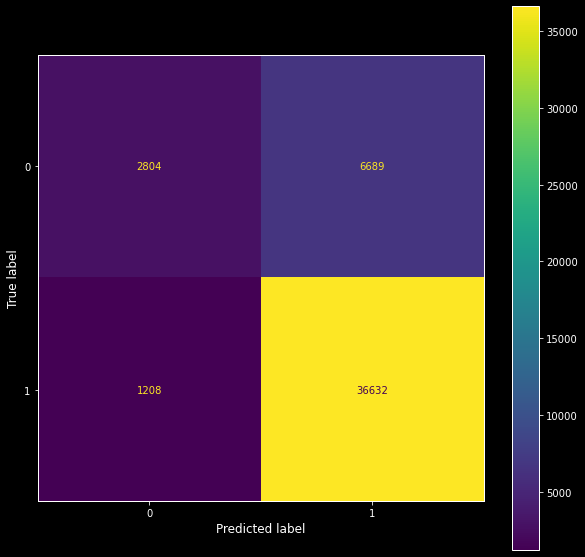

In [81]:
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_baseline, X_train[['ysign vehicle']], y_train_access, ax=ax)
ax.grid(False)

Plot the correctly and incorrectly classified data

In [82]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [83]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

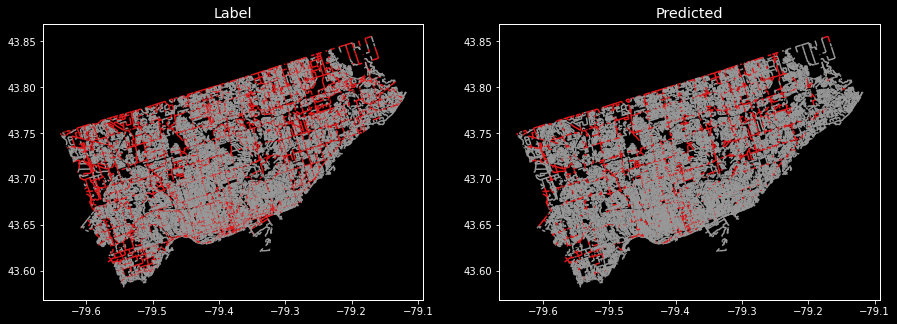

In [85]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

plotr = plotr.dropna()

# Figure
fig, axs = plt.subplots(figsize=(15,12), ncols=2)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='Set1')
plotr.plot(ax=axs[1], column=0, cmap='Set1')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[0].grid(False)
axs[1].grid(False)

plt.show()